In [3]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
import time
from gym import Env
from gym.spaces import Box, Discrete

In [4]:
class Game(Env):
    def __init__(self):
        super().__init__()

        self.observation_space = Box(low=0, high=255, shape=(700,1830,3), dtype=np.uint8)
        self.action_space = Discrete(4)  # 0 = No action, 1 = Forward, 2 = Up, 3 = Down

        self.cap = mss()
        self.game_location = {'top': 130, 'left': 45, 'width': 1830, 'height': 700}
        self.done_location = {'top': 310, 'left': 735, 'width': 450, 'height': 80}
        self.goal_location = {'top': 130, 'left': 1690, 'width': 170, 'height': 700}

    def step(self, action):
        # Action map for controlling the agent
        action_map = {
            0: 'no_op',  # No operation
            1: 'right',
            2: 'up',
            3: 'down'
        }
        
        # Apply action
        if action != 0:
            pydirectinput.press(action_map[action])

        # Check if game is done
        done, done_cap = self.get_done()

        # Get new observation
        new_observation = self.get_observation()

        # Reward calculation
        reward = 0
        curr = self.get_position()
        goal = self.goal_location['left']
        distance_to_goal = abs(goal - curr)

        # Penalty for distance from goal
        if not done:
            reward += -distance_to_goal * 0.01

            # Penalty for moving during a red light
            if self.is_red_light() and action in [1, 2, 3]:
                reward -= 10
                self.reset()
                
        else:
            # Reward or penalty based on game status
            if "win" in pytesseract.image_to_string(done_cap).lower():
                reward += 100
            else:
                reward -= 50

        # Info dictionary for logging
        info = {"current_position": curr}

        return new_observation, reward, done, info

    def get_position(self):
        obs = self.get_observation()

        # Define color to track (player's color)
        rgb_color = np.array([15, 102, 95])
        tolerance = 10
        lower_bound = np.clip(rgb_color - tolerance, 0, 255)
        upper_bound = np.clip(rgb_color + tolerance, 0, 255)

        # Create mask based on color range
        mask = cv2.inRange(obs, lower_bound, upper_bound)

        # Find contours of the player
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            player_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(player_contour)
            return x + w // 2  # Return the horizontal position (x-coordinate)

        return 0  # Return 0 if no player detected

    def is_red_light(self):
        red_light = np.array(self.cap.grab(self.done_location))[:, :, :3]
        
        # Fixed string concatenation
        red_light_cap = ['moved on', 'a red light']
        text = pytesseract.image_to_string(red_light).strip().lower()

        # Check if red light condition is met
        for phrase in red_light_cap:
            if phrase in text:
                return True
        return False

    def render(self):
        cv2.imshow('Game', self.get_observation())
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()

    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=960, y=590)
        return self.get_observation()

    def close(self):
        cv2.destroyAllWindows()

    def get_observation(self):
        # Grab the screen and convert to RGB
        raw = np.array(self.cap.grab(self.game_location))[:, :, :3]
        bgr_image = cv2.cvtColor(raw, cv2.COLOR_RGB2BGR)
        return bgr_image
    
    def preprocess_observation(self):
        # Resize the observation for the model
        resized_obs = cv2.resize(self.get_observation(), (84, 84), interpolation=cv2.INTER_AREA)
        return resized_obs
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:, :, :3]
        
        # Fixed string concatenation
        done_strings = ['You win', 'You win.', 'moved on a red light']

        done = False
        res = pytesseract.image_to_string(done_cap)[:4]

        # Check if game is over
        if res in done_strings:
            done = True

        return done, done_cap  

In [5]:
env = Game()

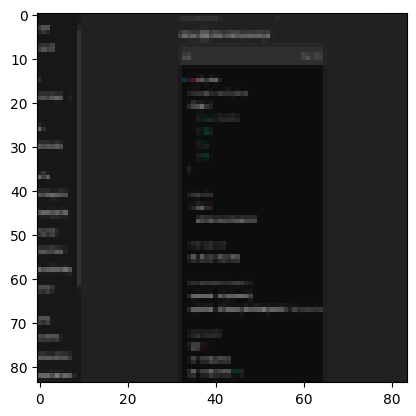

In [7]:
plt.imshow(env.preprocess_observation())

In [25]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [26]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [27]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [28]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [29]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [30]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=500, learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\jason\repos\Mugunghwa-kkochi-Pieossseubnida\venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


MemoryError: Unable to allocate 1.79 GiB for an array with shape (500, 1, 3, 700, 1830) and data type uint8

In [10]:
model.learn(total_timesteps=1000, callback=callback)

Logging to ./logs/DQN_2


KeyboardInterrupt: 